In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# 1. Data Loading

# Load the catalog file (this contains quake event times)
cat_directory = 'space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
catalog = pd.read_csv(cat_file)

# Load the seismic data for a single event (adjust paths based on your data)
data_directory = 'space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
filename = catalog.iloc[0]['filename'] + '.csv'  # Use first event for example
data = pd.read_csv(data_directory + filename)

# 2. Data Preprocessing

# Extract time (in relative seconds) and velocity data
time_rel = np.array(data['time_rel(sec)'])
velocity = np.array(data['velocity(m/s)'])

# Reshape the data for the model
window_size = 1000  # Define window size (you may need to experiment)
stride = 500  # Define stride (overlap between windows)
X = []
y = []

# Sliding window approach to create time windows
for i in range(0, len(velocity) - window_size, stride):
    X.append(velocity[i:i+window_size])  # Take windows of size `window_size`
    # Create labels based on quake events: 1 if quake, 0 otherwise
    quake_time = catalog['time_rel(sec)'].values[0]
    label = 1 if (quake_time >= time_rel[i] and quake_time < time_rel[i+window_size]) else 0
    y.append(label)

X = np.array(X)
y = np.array(y)


In [7]:

# Reshape X for input into the CNN-LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, window_size, 1)

# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the training+validation data into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 overall validation

Epoch 1/20
22/22 [==============================] - 14s 514ms/step - loss: 0.3339 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.9956
Epoch 2/20
22/22 [==============================] - 9s 408ms/step - loss: 2.4668e-04 - accuracy: 1.0000 - val_loss: 0.0512 - val_accuracy: 0.9956
Epoch 3/20
22/22 [==============================] - 9s 433ms/step - loss: 9.2135e-05 - accuracy: 1.0000 - val_loss: 0.0539 - val_accuracy: 0.9956
Epoch 4/20
22/22 [==============================] - 9s 388ms/step - loss: 3.0466e-05 - accuracy: 1.0000 - val_loss: 0.0547 - val_accuracy: 0.9956


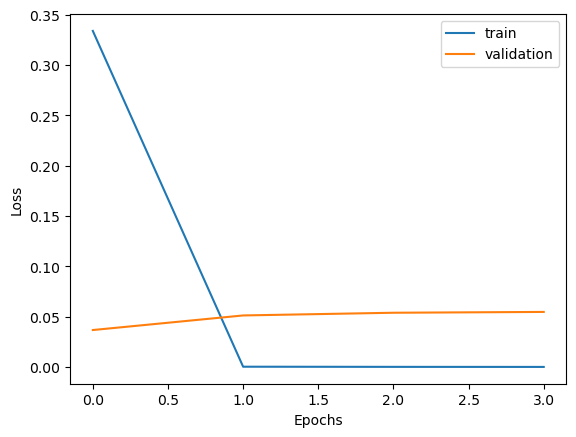

8/8 [==============================] - 1s 93ms/step - loss: 0.0367 - accuracy: 0.9956
Validation Accuracy: 99.56%
8/8 [==============================] - 1s 83ms/step


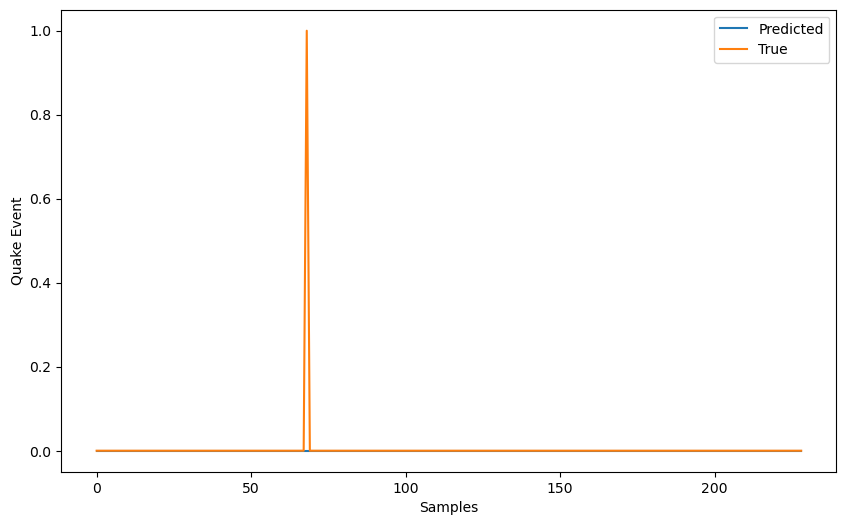

In [8]:

# 4. Model Building

# CNN-LSTM model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer
model.add(LSTM(100, return_sequences=False))

# Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output for binary classification (quake/no quake)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Model Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stop])

# 6. Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Model Evaluation on Validation Set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')

# 8. Make Predictions
predictions = model.predict(X_val)
predicted_labels = (predictions > 0.5).astype(int)

# Optional: Visualize the predictions vs actual labels
plt.figure(figsize=(10, 6))
plt.plot(predicted_labels, label='Predicted')
plt.plot(y_val, label='True')
plt.xlabel('Samples')
plt.ylabel('Quake Event')
plt.legend()
plt.show()

# 9. Save the model
model.save('seismic_detection_model.h5')


In [9]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

8/8 [==============================] - 1s 78ms/step - loss: 0.0367 - accuracy: 0.9956
Test Accuracy: 99.56%


In [16]:
import os
import numpy as np
import pandas as pd

# Function to load CSV seismic data from all folders
def load_seismic_data(folder):
    data = []
    catalog = []
    
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(subdir, file)
                if "catalog" in subdir.lower():
                    # If we're in the 'catalogs' folder, load the catalog file
                    catalog_data = pd.read_csv(file_path)
                    catalog.append(catalog_data)
                else:
                    # Otherwise, it's seismic data
                    seismic_data = pd.read_csv(file_path)
                    data.append(seismic_data)
    
    return data, catalog

# Load all lunar and mars data (training and test)
def load_all_data():
    base_dir = 'C:'
    
    # Load lunar training data (Apollo 12 Grade A)
    lunar_train_data, lunar_train_catalog = load_seismic_data(os.path.join(base_dir, 'lunar/training'))
    
    # Load lunar test data (Apollo 12, 15, 16 - Grades A and B)
    lunar_test_data, lunar_test_catalog = load_seismic_data(os.path.join(base_dir, 'lunar/test'))
    
    # Load mars training data
    mars_train_data, mars_train_catalog = load_seismic_data(os.path.join(base_dir, 'mars/training'))
    
    # Load mars test data
    mars_test_data, mars_test_catalog = load_seismic_data(os.path.join(base_dir, 'mars/test'))
    
    return {
        "lunar_train_data": lunar_train_data,
        "lunar_train_catalog": lunar_train_catalog,
        "lunar_test_data": lunar_test_data,
        "lunar_test_catalog": lunar_test_catalog,
        "mars_train_data": mars_train_data,
        "mars_train_catalog": mars_train_catalog,
        "mars_test_data": mars_test_data,
        "mars_test_catalog": mars_test_catalog,
    }

# Load all the data
all_data = load_all_data()

# Example: Inspect datasets
print(f"Lunar Train Data Samples: {len(all_data['lunar_train_data'])} files")
print(f"Lunar Test Data Samples: {len(all_data['lunar_test_data'])} files")
print(f"Mars Train Data Samples: {len(all_data['mars_train_data'])} files")
print(f"Mars Test Data Samples: {len(all_data['mars_test_data'])} files")

# Example: Inspect one of the datasets
print("Lunar Train Data Sample (Apollo 12):", all_data['lunar_train_data'][0].head())
print("Lunar Train Catalog Sample:", all_data['lunar_train_catalog'][0].head())


Lunar Train Data Samples: 0 files
Lunar Test Data Samples: 0 files
Mars Train Data Samples: 0 files
Mars Test Data Samples: 0 files


IndexError: list index out of range